# Code to find outliers from MAGeT segmentation
## Uses brain masks from fMRIPrep and MAGeT segmentation volumes from CSVs (../results/) generated by "collect_volumes.sh" script part of [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)

In [58]:
import nibabel as nib
import glob
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from lib.io_utils import *

### Paths

In [38]:
project_dir = '../../../../../'
data_dir = project_dir + 'data/preproc_T1s/'

cohort = 'PPMI'

masked_image_dir = data_dir + f'{cohort}/masked_images/'
maget_output = f'../results/{cohort}_volumes.csv'
participants_csv = f'../metadata/{cohort}_participants.txt'

print(f'Using {cohort} cohort')

Using PPMI cohort


## Read participants info

In [53]:
participants = pd.read_csv(participants_csv)
print(f'Found {len(participants)} participants')
participants.head()

Found 116 participants


,participants
0,sub-3000
1,sub-3004
2,sub-3008
3,sub-3011
4,sub-3013


### Grab TBV from brain masks

In [56]:
mask_name_suffix = '_run-1_desc-masked_preproc_T1w.nii.gz'

brain_vol_list = []

for subject in participants['participants'].values:
    # print('Subject name: {}'.format(subject))
    mask_path = f'{masked_image_dir}{subject}{mask_name_suffix}' 
    mask = nib.load(mask_path).get_fdata()
    brain_vol = np.sum(mask>0)
    brain_vol_list.append(brain_vol)

vol_df = participants.copy()
vol_df = vol_df.rename(columns={'participants':'Subject'})
vol_df['TBV'] = brain_vol_list
vol_df.head() 

,Subject,TBV
0,sub-3000,1106080
1,sub-3004,1148427
2,sub-3008,915347
3,sub-3011,1208866
4,sub-3013,1189621


In [55]:
## Read MAGeT volumes
cohort = 'PPMI'
maget_output = f'../results/{cohort}_volumes.csv'
maget_df = pd.read_csv(maget_output,sep=',',header=0)
maget_df.head()

,Subject,L_I_II,L_III,L_IV,L_V,L_VI,L_Crus_I,L_Crus_II,L_VIIB,L_VIIIA,...,R_V,R_VI,R_Crus_I,R_Crus_II,R_VIIB,R_VIIIA,R_VIIIB,R_IX,R_X,R_CM
0,sub-3000,57.5999,857.998,2014.79,3339.59,6329.98,12459.6,8973.58,4505.99,6110.38,...,3290.39,6993.58,12590.4,10554.00,5919.58,5062.79,2974.79,3403.19,632.398,8511.58
1,sub-3004,60.0002,802.803,2054.41,3588.01,6846.03,11181.6,8116.83,3967.22,5569.22,...,3602.41,7239.63,12391.2,9376.84,4996.82,3848.41,2913.61,2826.01,728.403,9579.64
2,sub-3008,64.7998,707.998,1689.60,3413.99,7543.18,11572.8,8228.38,3663.59,5173.19,...,3464.39,7912.78,12068.4,9715.18,4279.19,3754.79,2807.99,2841.59,573.599,7627.18
3,sub-3011,74.3998,1096.800,2791.19,3863.99,8019.58,16363.2,10261.20,5205.59,6689.98,...,4299.59,8729.98,17437.2,12393.60,6016.78,4731.59,4118.39,4096.79,649.198,10372.80
4,sub-3013,69.5998,920.398,2464.79,3980.39,10233.60,12747.6,8141.98,4645.19,5822.39,...,4163.99,9671.98,14224.8,9508.78,4609.19,4763.99,3321.59,3232.79,635.998,9967.17


## Cerebellar lobule labels

In [64]:
cols_L = ['L_I_II', 'L_III', 'L_IV', 'L_V', 'L_VI', 'L_Crus_I','L_Crus_II', 'L_VIIB', 'L_VIIIA', 'L_VIIIB', 'L_IX', 'L_X', 'L_CM']
cols_R = ['R_I_II', 'R_III', 'R_IV', 'R_V', 'R_VI', 'R_Crus_I', 'R_Crus_II','R_VIIB', 'R_VIIIA', 'R_VIIIB', 'R_IX', 'R_X', 'R_CM']

v_lines = len(cols_L)

## Plot total CB volumes

Normalizing cerebellum volume with TBV


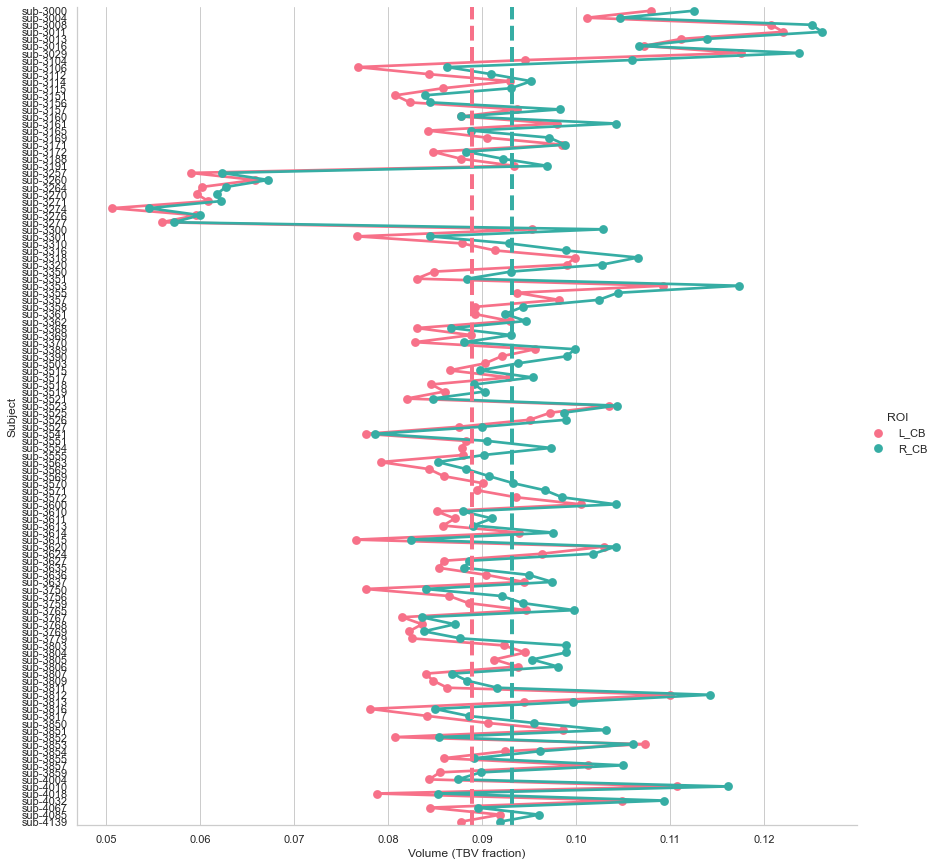

In [66]:
plot_df = pd.merge(maget_df, vol_df, on='Subject').copy()
plot_df['L_CB'] = plot_df[cols_L].sum(axis=1)
# plot_df['R_CB'] = plot_df[cols_R].sum(axis=1)

normalize = True

if normalize:
    print('Normalizing cerebellum volume with TBV')
    plot_df['L_CB'] = plot_df['L_CB']/(0.5*plot_df['TBV'])
    plot_df['R_CB'] = plot_df['R_CB']/(0.5*plot_df['TBV'])

vol_min = np.min(plot_df[['L_CB','R_CB']].values)
vol_max = np.max(plot_df[['L_CB','R_CB']].values)
L_CB_mean = np.mean(plot_df[['L_CB']].values)
R_CB_mean = np.mean(plot_df[['R_CB']].values)

palette = sns.color_palette('husl',2)

with sns.axes_style("whitegrid"):
    plot_df = pd.melt(plot_df, id_vars = ['Subject','TBV'], value_vars = ['L_CB','R_CB'] , 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(x='volume', y='Subject', hue='ROI', kind='point',aspect=1, height=12, palette = palette,
                    data=plot_df)

    plt.axvline(L_CB_mean, ls='--',lw=4, c=palette[0])
    plt.axvline(R_CB_mean, ls='--',lw=4, c=palette[1])
    # g.set_xticklabels(rotation=50)
    if normalize:
        plt.xlabel('Volume (TBV fraction)')

## Subject outliers based on L or R CB volume

In [75]:
n_outliers = 9 # Estimated baesd on the plot 
L_CB_vols = plot_df[plot_df['ROI']=='L_CB'].sort_values(['volume'])['Subject'].values
R_CB_vols = plot_df[plot_df['ROI']=='R_CB'].sort_values(['volume'])['Subject'].values
L_CB_under = L_CB_vols[:n_outliers] 
R_CB_under = R_CB_vols[:n_outliers] 
L_CB_over = L_CB_vols[-n_outliers:] 
R_CB_over = R_CB_vols[-n_outliers:]
CB_under = set(L_CB_under) | set(R_CB_under)
CB_over = set(L_CB_over) | set(R_CB_over) 

print(f'Potential outliers based on left CB:\nunderestimates: {L_CB_under}\noverestimates: {L_CB_over}')
print(f'Potential outliers based on right CB:\nunderestimates: {R_CB_under}\noverestimates: {R_CB_over}')

print(f'Potential outlier based on left of right CB:\nunderestimates: {CB_under}\noverestimates: {CB_over}')

Potential outliers based on left CB:
underestimates: ['sub-3274' 'sub-3277' 'sub-3257' 'sub-3276' 'sub-3270' 'sub-3264'
 'sub-3271' 'sub-3260' 'sub-3615']
overestimates: ['sub-3853' 'sub-3000' 'sub-3353' 'sub-3812' 'sub-4010' 'sub-3013'
 'sub-3029' 'sub-3008' 'sub-3011']
Potential outliers based on right CB:
underestimates: ['sub-3274' 'sub-3277' 'sub-3276' 'sub-3270' 'sub-3271' 'sub-3257'
 'sub-3264' 'sub-3260' 'sub-3541']
overestimates: ['sub-4032' 'sub-3000' 'sub-3013' 'sub-3812' 'sub-4010' 'sub-3353'
 'sub-3029' 'sub-3008' 'sub-3011']
Potential outlier based on left of right CB:
underestimates: {'sub-3271', 'sub-3541', 'sub-3270', 'sub-3260', 'sub-3615', 'sub-3257', 'sub-3277', 'sub-3274', 'sub-3264', 'sub-3276'}
overestimates: {'sub-3353', 'sub-3013', 'sub-4032', 'sub-3029', 'sub-3000', 'sub-3853', 'sub-3008', 'sub-4010', 'sub-3011', 'sub-3812'}


## Plot ROI volumes

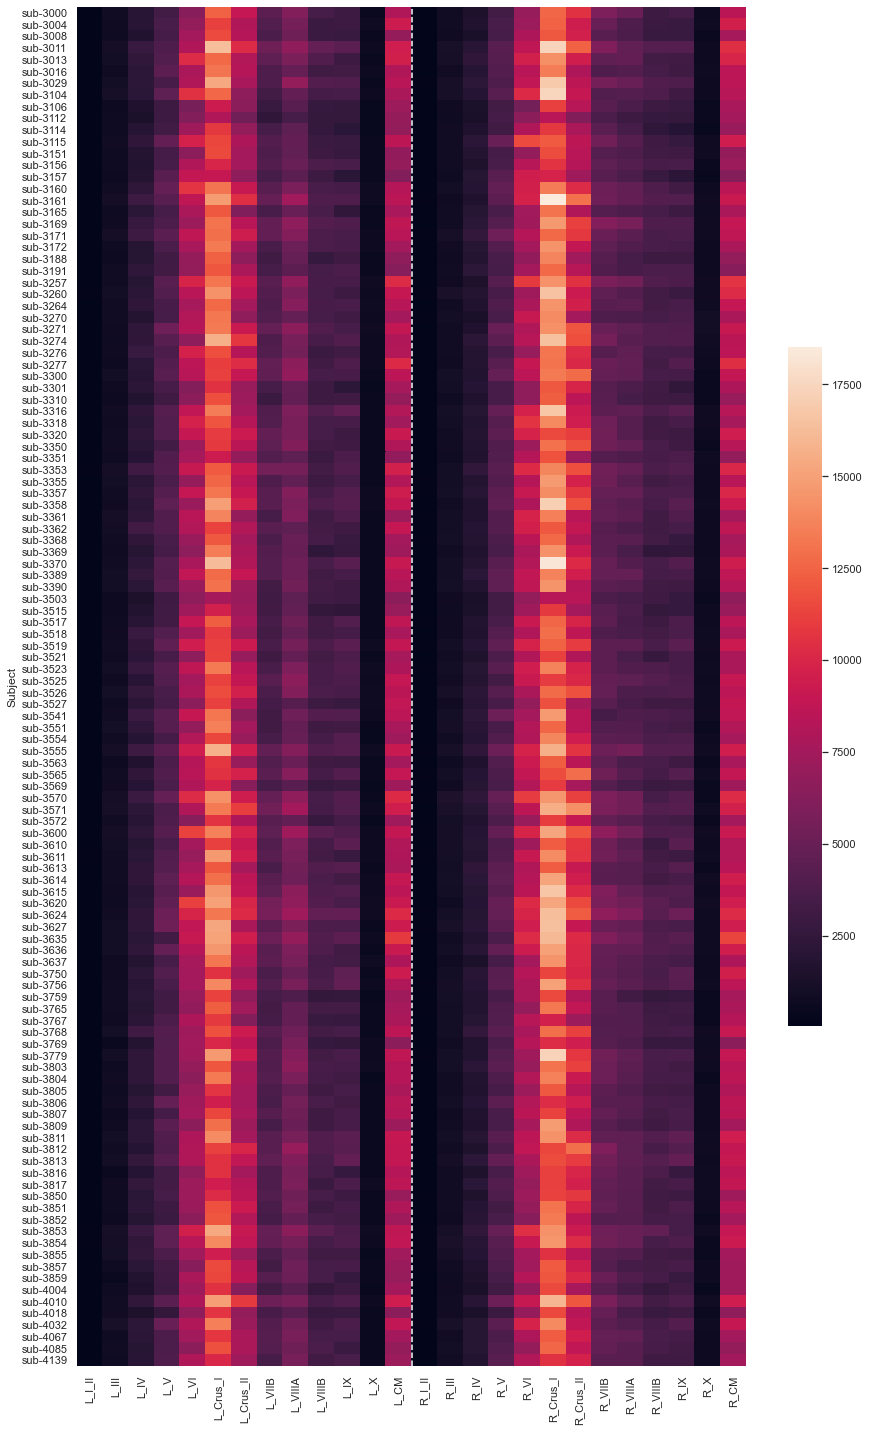

In [65]:
plot_df = plot_df = pd.merge(maget_df, vol_df, on='Subject').copy()

plot_df = plot_df.set_index('Subject')
plot_df = plot_df[cols_L + cols_R ]
sns.set(font_scale=1)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 25))
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5})
    plt.axvline(v_lines, ls='--',c='white')